In [1]:
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import hub
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchaudio

import numpy as np

from sklearn.metrics import f1_score, recall_score, precision_score, balanced_accuracy_score, accuracy_score, classification_report

import scipy

from tqdm import tqdm

from src.utils import AphasiaDatasetMFCC, AphasiaDatasetSpectrogram, AphasiaDatasetWaveform

from collections import Counter
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain

import matplotlib.pyplot as plt

2025-05-14 14:16:28.106689: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 14:16:28.115946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747221388.127333   11536 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747221388.130757   11536 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 14:16:28.142407: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
SEED = 1984

np.random.seed(SEED)
torch.manual_seed(SEED)

gen = torch.Generator()
gen.manual_seed(SEED)

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
AUDIO_LENGTH = 6_000
SEQUENCE_LENGTH = 31
MFCC = 128
print(f"It's {DEVICE} time!!!")

It's cuda time!!!


In [4]:
DATA_DIR = os.path.join('..', 'data')
VOICES_DIR = os.path.join(DATA_DIR, 'Voices_wav')
APHASIA_DIR = os.path.join(VOICES_DIR, 'Aphasia')
NORM_DIR = os.path.join(VOICES_DIR, 'Norm')

In [5]:
augmentations = Compose([
                AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.02, p=0.75),
                TimeStretch(min_rate=0.8, max_rate=1.2, p=0.75),
                PitchShift(min_semitones=-3, max_semitones=3, p=0.75),
                Shift(min_shift=-0.3, max_shift=0.3, p=0.75),
                Gain(min_gain_db=-8, max_gain_db=8, p=0.75),
            ])

In [6]:
train_dataset = AphasiaDatasetWaveform(os.path.join(DATA_DIR, "train_filenames_mc_6.csv"), VOICES_DIR, target_sample_rate=16_000, file_format="wav", transforms=augmentations)
test_dataset = AphasiaDatasetWaveform(os.path.join(DATA_DIR, "val_filenames_mc_6.csv"), VOICES_DIR, target_sample_rate=16_000, file_format="wav")
val_dataset = AphasiaDatasetWaveform(os.path.join(DATA_DIR, "test_filenames_mc_6.csv"), VOICES_DIR, target_sample_rate=16_000, file_format="wav")

# Балансировка классов для train
train_labels = [label for _, label in train_dataset.data]
class_counts = Counter(train_labels)
if len(class_counts) < 2:
    raise ValueError("Один из классов отсутствует в тренировочном наборе")

class_weights = {label: 1.0 / count for label, count in class_counts.items()}
weights = [class_weights[label] for _, label in train_dataset.data]
train_sampler = WeightedRandomSampler(weights, num_samples=len(train_dataset), replacement=True)


In [7]:
class_counts 

Counter({2: 1261, 1: 843})

In [8]:
counts = torch.tensor([1 / x[1] for x in sorted(list(class_counts.items()), reverse=False)], dtype=torch.float)
counts

tensor([0.0012, 0.0008])

In [9]:
weights = nn.functional.softmax(counts, dim=0)
weights

tensor([0.5001, 0.4999])

In [10]:
MAX_LEN = 240_000

In [11]:
def pad_sequence(batch):
    if not batch:
        return torch.zeros(0), torch.zeros(0)
    
    seq, labels = zip(*batch)
    # print(seq[1], labels)
    max_len = max(s.shape[1] for s in seq)
    # print(seq[0].shape)

    # print(seq[0].shape)
    padded = torch.zeros(len(seq), max_len)
    for i, s in enumerate(seq):
        padded[i, :s.shape[1]] = s[0, :max_len]
    
    return padded, torch.stack(labels) - 1

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=4, sampler=train_sampler, collate_fn=pad_sequence, drop_last=True, num_workers=6)
# test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=pad_sequence, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=pad_sequence, drop_last=True, num_workers=6)

In [13]:
from termcolor import colored
from collections import defaultdict

def beautiful_int(i):
    i = str(i)
    return ".".join(reversed([i[max(j, 0):j+3] for j in range(len(i) - 3, -3, -3)]))

# Считаем общее число параметров в нашей модели
def model_num_params(model, verbose_all=True, verbose_only_learnable=False):
    sum_params = 0
    sum_learnable_params = 0
    submodules = defaultdict(lambda : [0, 0])
    for name, param in model.named_parameters():
        num_params = np.prod(param.shape)
        if verbose_all or (verbose_only_learnable and param[1].requires_grad):
            print(
                colored(
                    '{: <42} ~  {: <9} params ~ grad: {}'.format(
                        name,
                        beautiful_int(num_params),
                        param.requires_grad,
                    ),
                    {True: "green", False: "red"}[param.requires_grad],
                )
            )
        sum_params += num_params
        sm = name.split(".")[0]
        submodules[sm][0] += num_params
        if param.requires_grad:
            sum_learnable_params += num_params
            submodules[sm][1] += num_params
    print(
        f'\nIn total:\n  - {beautiful_int(sum_params)} params\n  - {beautiful_int(sum_learnable_params)} learnable params'
    )

    for sm, v in submodules.items():
        print(
            f"\n . {sm}:\n .   - {beautiful_int(submodules[sm][0])} params\n .   - {beautiful_int(submodules[sm][1])} learnable params"
        )
    return sum_params, sum_learnable_params


# sum_params, sum_learnable_params = model_num_params(hubert)

In [14]:
fgru_hidden_size = 64
tgru_hidden_size = 128

count = 10


def train(model, train_loader, optimizer, criterion, device="cuda", epoch=-1, draw_every=1):
    total_train_loss = 0
    total_train_acc = 0
    total_train_f1 = 0

    for features, target in tqdm(train_loader):
        features, target = features.to(device), target.to(device)
        optimizer.zero_grad()
    
        output = model(features)# .logits

        preds = torch.argmax(output, dim=-1).cpu().detach().numpy()
        # train_acc.append(accuracy_score(target.cpu().detach().numpy(), preds))
        # print(output.shape, target.shape)
        # print(output)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    
        total_train_loss += loss.detach().item()
        total_train_acc += accuracy_score(target.cpu().detach().numpy(), preds)
        total_train_f1 += f1_score(target.cpu().detach().numpy(), preds, average='macro')
        
    return (model, optimizer, total_train_loss / len(train_loader), 
            total_train_acc / len(train_loader), total_train_f1 / len(train_loader))
            
def evaluate(model, test_loader, criterion, device="cuda", epoch=-1, draw_every=1):
    total_val_loss = 0
    total_val_acc = 0
    total_val_f1 = 0

    for features, target in tqdm(test_loader):
        features, target = features.to(device), target.to(device)
    
        output = model(features)# .logits

        preds = torch.argmax(output, dim=-1).cpu().detach().numpy()
        # train_acc.append(accuracy_score(target.cpu().detach().numpy(), preds))

        loss = criterion(output, target)
        loss.backward()
    
        total_val_loss += loss.detach().item()
        total_val_acc += accuracy_score(target.cpu().detach().numpy(), preds)
        total_val_f1 += f1_score(target.cpu().detach().numpy(), preds, average='macro')
        
    return (total_val_loss / len(test_loader), 
            total_val_acc / len(test_loader), total_val_f1 / len(test_loader))

In [15]:
from IPython.display import clear_output

def get_model_name(chkp_folder, model_name=None):
    # Выбираем имя чекпоинта для сохранения
    if model_name is None:
        if os.path.exists(chkp_folder):
            num_starts = len(os.listdir(chkp_folder)) + 1
        else:
            num_starts = 1
        model_name = f'model#{num_starts}'
    else:
        if "#" not in model_name:
            model_name += "#0"
    changed = False
    while os.path.exists(os.path.join(chkp_folder, model_name + '.pt')):
        model_name, ind = model_name.split("#")
        model_name += f"#{int(ind) + 1}"
        changed=True
    if changed:
        warnings.warn(f"Selected model_name was used already! To avoid possible overwrite - model_name changed to {model_name}")
    return model_name

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def learning_loop(
    model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    scheduler=None,
    min_lr=None,
    epochs=10,
    val_every=1,
    draw_every=1,
    with_noise=True,
    with_rir=True,
    model_name=None,
    chkp_folder="../checkpoints/hubert_chkp",
    plots=None,
    starting_epoch=0,
    device="cuda",
):
    model_name = get_model_name(chkp_folder, model_name)
    
    if plots is None:
        plots = {
            'train loss': [],
            'train acc': [],
            'train f1': [],
            'val loss': [],
            'val acc': [],
            'val f1': [],
            "learning rate": [],
        }
        
    max_f1 = 0

    for epoch in np.arange(1, epochs+1) + starting_epoch:
        print(f'#{epoch}/{epochs}:')

        plots['learning rate'].append(get_lr(optimizer))
        
        model, optimizer, train_loss, train_acc, train_f1 = train(model, train_loader, optimizer,
            criterion, device=device, epoch=epoch, draw_every=draw_every)
        # print(train_nisqa)
        plots['train loss'].append(train_loss)
        plots['train acc'].append(train_acc)
        plots['train f1'].append(train_f1)
        

        if not (epoch % val_every):
            # print("validate")
            val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion, device=device)
            plots['val loss'].append(val_loss)
            plots['val acc'].append(val_acc)
            plots['val f1'].append(val_f1)
            
            # Сохраняем модель
            if not os.path.exists(chkp_folder):
                os.makedirs(chkp_folder)
            
            if max_f1 <= val_f1:
                torch.save(
                    {
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
                        'plots': plots,
                    },
                    os.path.join(chkp_folder, model_name + '.pt'),
                )
                max_f1 = val_f1
            
            # Шедулинг
            if scheduler:
                try:
                    scheduler.step()
                except:
                    scheduler.step(metrics=val_loss)

        if not (epoch % draw_every):
            clear_output(True)

            hh = 2
            ww = 2
            plt_ind = 1
            fig, ax = plt.subplots(hh, ww, figsize=(25, 12))
            fig.suptitle(f'#{epoch}/{epochs}:')


            plt.subplot(hh, ww, plt_ind)
            plt.title('Learning rate')
            plt.plot(plots["learning rate"], 'b.-', label='lr', alpha=0.7)
            plt.legend()
            plt_ind += 1

            plt.subplot(hh, ww, plt_ind)
            plt.title('Loss')
            plt.plot(np.arange(1, epoch + 1), plots['train loss'], 'r.-', label='train', alpha=0.7)
            plt.plot(np.arange(1, epoch + 1), plots['val loss'], 'g.-', label='val', alpha=0.7)
            plt.grid()
            plt.legend()
            plt_ind += 1
            
            plt.subplot(hh, ww, plt_ind)
            plt.title('Accuracy')
            plt.plot(np.arange(1, epoch + 1), plots['train acc'], 'r.-', label='train', alpha=0.7)
            plt.plot(np.arange(1, epoch + 1), plots['val acc'], 'g.-', label='val', alpha=0.7)
            plt.grid()
            plt.legend()
            plt_ind += 1
            
            plt.subplot(hh, ww, plt_ind)
            plt.title('F1-score')
            plt.plot(np.arange(1, epoch + 1), plots['train f1'], 'r.-', label='train', alpha=0.7)
            plt.plot(np.arange(1, epoch + 1), plots['val f1'], 'g.-', label='val', alpha=0.7)
            plt.grid()
            plt.legend()
            plt_ind += 1

            plt.show()
            display(fig)
                        
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break

    
    return model, optimizer, plots

In [16]:
from transformers import HubertModel

class HuBERTClassifier(nn.Module):

    def __init__(self, num_labels: int = 2, unfreeze: float = 0.5):
        super(HuBERTClassifier, self).__init__()

        # self.hubert = HubertForSequenceClassification.from_pretrained(
        #     "facebook/hubert-base-ls960",
        #     num_labels=num_labels,
        # )

        # self.hubert = HubertForSequenceClassification.from_pretrained(
        #     "xbgoose/hubert-large-speech-emotion-recognition-russian-dusha-finetuned",
        #     num_labels=num_labels,
        # )

        self.hubert = HubertModel.from_pretrained(
            "facebook/hubert-base-ls960",
            # num_labels=num_labels,
        )



        self.num_parameters = len(list(self.hubert.parameters()))

        for ind, param in enumerate(self.hubert.parameters()):

            if ind + 4 < int(self.num_parameters * unfreeze):
                param.requires_grad = False
            else:
                param.requires_grad = True

        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(768, num_labels)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, audio):
        # return self.hubert(audio)
        x= self.hubert(audio).last_hidden_state
        # print(x.shape)
        x = x.permute(0, 2, 1)
        x_emb = self.avg_pool(x).squeeze(-1)
        # print(x.shape)
        x = self.fc(x_emb)
        return self.softmax(x), x_emb

In [17]:
from torch.optim import Adam

hubert = HuBERTClassifier(num_labels=len(class_counts), unfreeze=0.95).to(DEVICE)

# hubert = HuBERTClassifier(num_labels=4, unfreeze=0.9).to(DEVICE)

optimizer = Adam(hubert.parameters(), lr=1e-5, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.25).to(DEVICE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, threshold=0.1, mode="min", threshold_mode="abs")

In [18]:
sum_params, sum_learnable_params = model_num_params(hubert)

hubert.masked_spec_embed                   ~  768       params ~ grad: False
hubert.feature_extractor.conv_layers.0.conv.weight ~  5.120     params ~ grad: False
hubert.feature_extractor.conv_layers.0.layer_norm.weight ~  512       params ~ grad: False
hubert.feature_extractor.conv_layers.0.layer_norm.bias ~  512       params ~ grad: False
hubert.feature_extractor.conv_layers.1.conv.weight ~  786.432   params ~ grad: False
hubert.feature_extractor.conv_layers.2.conv.weight ~  786.432   params ~ grad: False
hubert.feature_extractor.conv_layers.3.conv.weight ~  786.432   params ~ grad: False
hubert.feature_extractor.conv_layers.4.conv.weight ~  786.432   params ~ grad: False
hubert.feature_extractor.conv_layers.5.conv.weight ~  524.288   params ~ grad: False
hubert.feature_extractor.conv_layers.6.conv.weight ~  524.288   params ~ grad: False
hubert.feature_projection.layer_norm.weight ~  512       params ~ grad: False
hubert.feature_projection.layer_norm.bias  ~  512       params ~ grad:

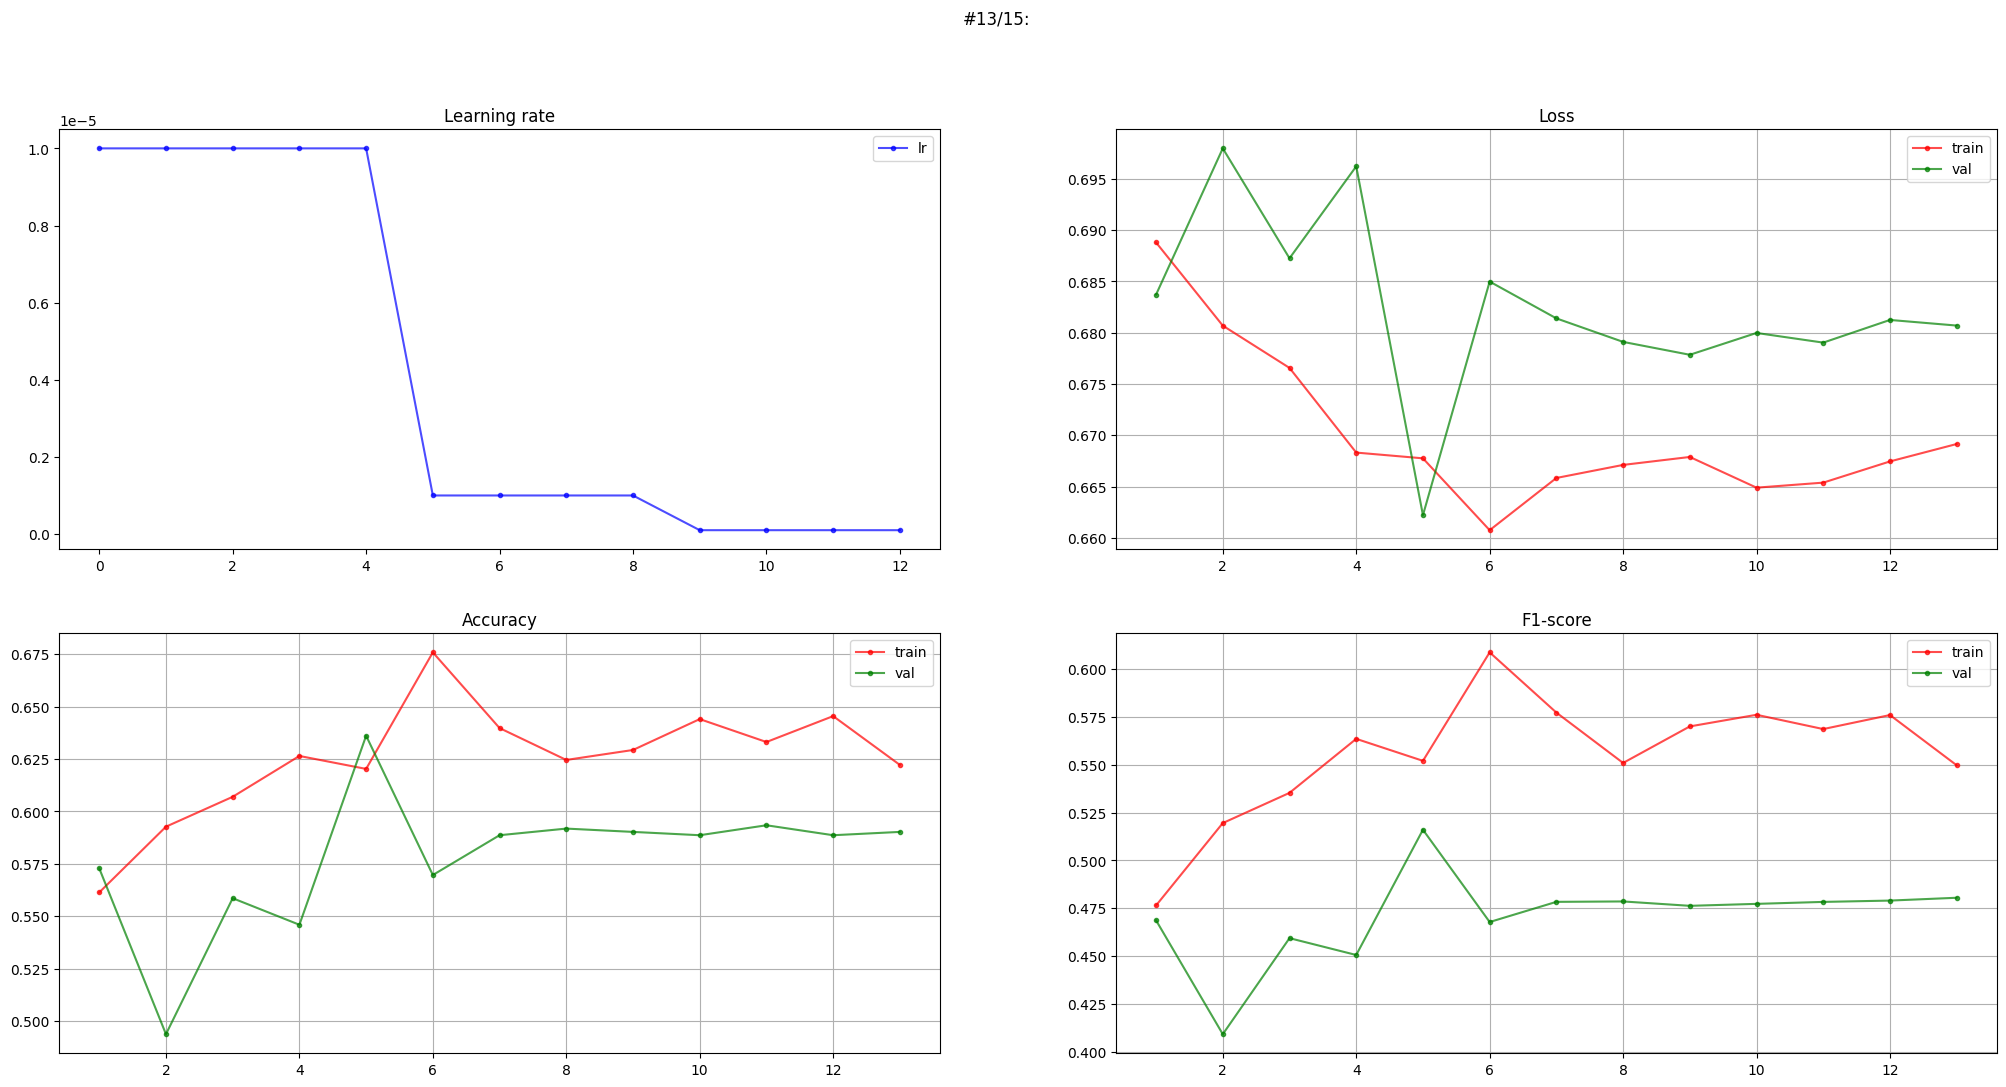

Learning process ended with early stop after epoch 13


In [19]:
hubert, optimizer, plots = learning_loop(hubert, optimizer, criterion, train_dataloader, val_dataloader, scheduler, draw_every=1, epochs=15, min_lr=1e-7, with_noise=False, with_rir=False, model_name="hubert_2_cls")

In [20]:
# hubert, train_l, val_l, train_acc, val_acc = train_model(hubert, train_dataloader, val_dataloader, epochs=15, lr=0.001, device=DEVICE)

In [21]:
# CHECKPOINTS_DIR = os.path.join("..", "checkpoints")

In [22]:
# if not os.path.exists(os.path.join(CHECKPOINTS_DIR, "hubert_chkp")):
#     os.makedirs(os.path.join(CHECKPOINTS_DIR, "hubert_chkp"))
# 
# state_d = torch.load(os.path.join(CHECKPOINTS_DIR, "hubert_chkp", "hubert_3_cls#7.pt"), weights_only=False)
# hubert = HuBERTClassifier(num_labels=len(class_counts), unfreeze=0.95).to(DEVICE)
# hubert.load_state_dict(state_d["model_state_dict"])

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.style.use('dark_background')

def test_model(model, test_data):
    model = model.to(DEVICE)

    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for features, target in tqdm(test_data):
            features = features.to(DEVICE)
            target = target.to(DEVICE) - 1

            label = model(features).to("cpu").detach().numpy().squeeze()
            preds.append(label.argmax(axis=-1))
            targets.append(target.to("cpu").item())

    preds = np.array(preds)
    # print(targets)
    print(classification_report(targets, preds))    
    cm = confusion_matrix(targets, preds, normalize="true")
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()
    return preds

100%|██████████| 635/635 [00:21<00:00, 29.70it/s]

              precision    recall  f1-score   support

           0       0.31      0.65      0.42       181
           1       0.75      0.42      0.54       454

    accuracy                           0.49       635
   macro avg       0.53      0.53      0.48       635
weighted avg       0.62      0.49      0.51       635



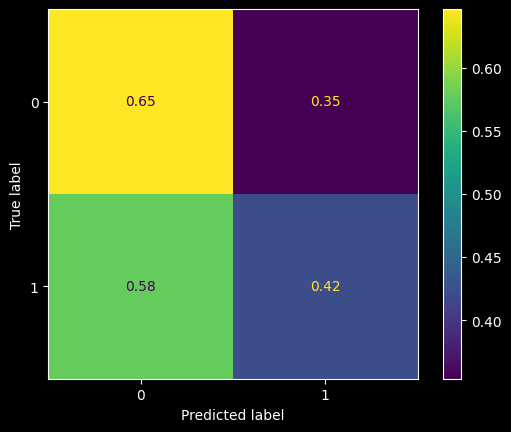

In [24]:
hubert_preds = test_model(hubert, test_dataset)

In [25]:
def test_model_for_each_participant(model, test_data):
    model = model.to("cpu")
        
    model.eval()

    test_data["ID"] = test_data["file_name"].apply(
        lambda x: str(x).split("-")[0] + str(x).split("-")[1])
    test_data.head()
    IDs = test_data["ID"].unique()

    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for participant_id in tqdm(IDs):
            participant_samples = test_data[test_data["ID"] == participant_id]
            preds = []
            for ind, participant_sample in participant_samples.iterrows():

                sgnl_path = participant_sample["file_name"]

                if participant_sample['label'] == 0:
                    sgnl_path = os.path.join(NORM_DIR, sgnl_path)
                else:
                    sgnl_path = os.path.join(APHASIA_DIR, sgnl_path)
                    
                chunks = train_dataset.process_audio(sgnl_path)

                padded = torch.zeros(len(chunks), MAX_LEN)
                for i, s in enumerate(chunks):
                    padded[i, :s.shape[1]] = s[0, :MAX_LEN]
                pred = model(torch.from_numpy(np.array(padded))).detach().numpy().squeeze().argmax(axis=-1)
                # print(type(pred))
                if isinstance(pred, np.ndarray):
                    # print(pred)
                    preds.extend(pred.tolist())
                else:
                    preds.append(pred)
            labels = participant_samples["label"]
  
            pred = scipy.stats.mode(np.array(preds))

            all_preds.append(pred.mode)
        
            all_labels.append(labels.values[0] - 1)
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    print(classification_report(all_labels, all_preds))
    
    return all_preds